# Inspecting condition differences using HsMM

There are several ways to estimate and inspect condition differences:
1. Estimate separate stage durations across conditions
2. Estimate separate bump magnitudes across conditions
3. Estimate entirely different models for each condition

To illustrate these approaches we will rely on the data exctracted in Tutorial 1

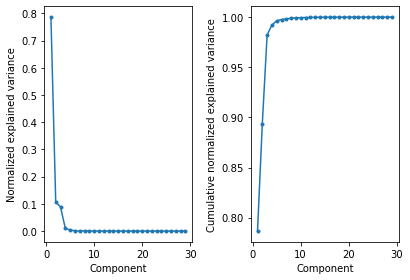

How many PCs (90 and 99% explained variance at component n3 and n4)? 4


In [2]:
import numpy as np
import xarray as xr
import hsmm_mvpy as hsmm

cpus=5#set the number of cores to use for all the code

eeg_data = xr.load_dataset('sample_data/sample_data.nc')

#We create also the position array for the electrodes as we are going to need them to plot the bump topologies
from mne import channels
montage = dict(channels.make_standard_montage('easycap-M1').get_positions())['ch_pos']#In this case electrodes are positioned according to the 10-20 system
positions = np.array([montage[x][:2] for x in eeg_data['electrodes'].values])#Extract x and y positions of each electrode

#And we transform as in the previous tutorial
unstacked_data = hsmm.utils.transform_data(eeg_data)
hsmm_data = hsmm.utils.stack_data(unstacked_data)

## Applying HsMM for all conditions

For the two first applications we rely on a fit of HsMM on all the data.

In [3]:
init = hsmm.models.hsmm(hsmm_data, sf=eeg_data.sfreq, cpus=cpus)

As we don't know yet the number of bumps, we will use the ```backward_estimation()``` method (see Tutorial 2)

In [4]:
bests = init.backward_estimation()

Estimating all solutions for maximal number of bumps (6) with 0 random starting points
Estimating parameters for 6 bumps model with 0 random starting points
Likelihood of uninitialized parameters has been preferred over initialized model. Consider adding starting points?
Parameters estimated for 6 bumps model
Estimating all solutions for 5 number of bumps
Estimating all solutions for 4 number of bumps
Estimating all solutions for 3 number of bumps
Estimating all solutions for 2 number of bumps
Estimating all solutions for 1 number of bumps


And plot the resulting solutions

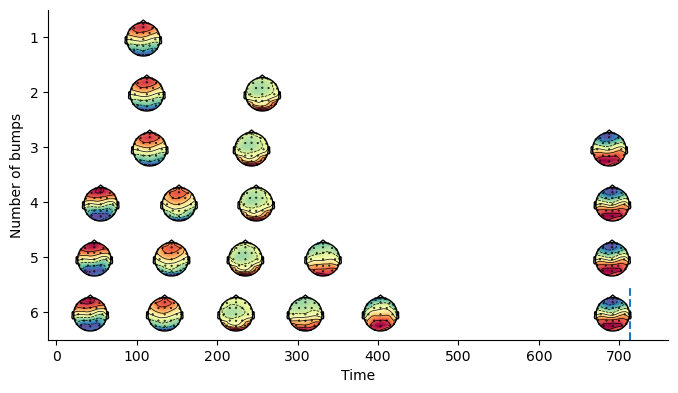

In [5]:
topo_bests = init.multiple_topologies(eeg_data, bests.eventprobs)
times = [init.bump_times(x) for x in bests.eventprobs]

hsmm.visu.plot_topo_timecourse(topo_bests[::-1], times,
                          positions, bump_size=init.bump_width_samples, time_step = 1000/eeg_data.sfreq, magnify=2, 
                          times_to_display = np.mean(init.ends - init.starts), 
                          figsize=(8,4), ylabels={'Number of bumps':np.arange(init.max_bumps,0,-1)})

Next we test the required number of bumps with the LOOCV approache (see tutorial 3)

LOOCV for model with 1 bump(s)
LOOCV for model with 2 bump(s)
LOOCV for model with 3 bump(s)
LOOCV for model with 4 bump(s)
LOOCV for model with 5 bump(s)
LOOCV for model with 6 bump(s)


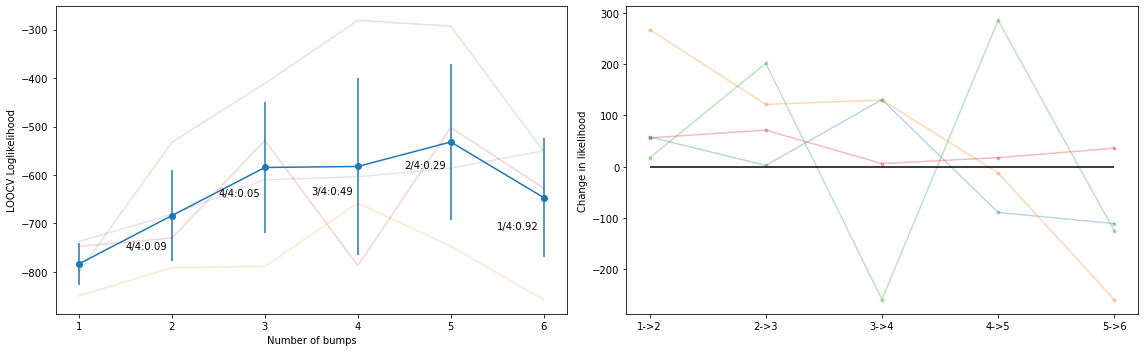

In [6]:
loocv = hsmm.utils.loocv_mp(init, unstacked_data, bests, cpus=cpus)
hsmm.visu.plot_LOOCV(loocv, pvals=True, test='t-test', indiv=True)#Colored shaded lines represent individuals

Based on the numer of participant that improved (4/4) and the p-value from a one-sided one-sample t-test (<.05), the model with 3 bumps appears to be the prefered model after the LOOCV procedure.

With only four participants it is not very convincing but the 3 bump solution emerges so let's go with that one

## 1. Estimate separate stage durations across speed conditions

In a design with a speed-accuracy trade-off such as this one, predictions on stages are rather straightforward. We expect that the main difference in latencies should be found in the decision stage although we can expect effects on other stages [Steinmann2018, Weindel2021]. To leave enough flexibility to the model we do not constrain the latencies to be fixed across conditions, but if we want to avoid extra degrees of freedom and test a hypothesis on a specific stage we can also fix stage duration as we do for magnitudes (see next application).

In [7]:
subset = unstacked_data.where(eeg_data.event.str.contains('SP'),drop=True)#select the conditions where participants needs to be fast
hsmm_speed_data = hsmm.utils.stack_data(subset)
init_speed = hsmm.models.hsmm(hsmm_speed_data,
                       sf=eeg_data.sfreq, cpus=cpus, estimate_magnitudes=False)#Here we turn off the estimation of magnitudes so only stage durations are free to vary

subset = unstacked_data.where(eeg_data.event.str.contains('AC'),drop=True)#select the conditions where participants needs to be accurate
hsmm_accuracy_data = hsmm.utils.stack_data(subset)
init_accuracy = hsmm.models.hsmm(hsmm_accuracy_data,
                       sf=eeg_data.sfreq, cpus=cpus, estimate_magnitudes=False)

In [8]:
n_bump = 3
speed = init_speed.fit_single(n_bump, magnitudes=bests.sel(n_bumps=n_bump).magnitudes)#Having fixed magnitudes we need to pass those estimated from the previous iterative method
accuracy = init_accuracy.fit_single(n_bump, magnitudes=bests.sel(n_bumps=n_bump).magnitudes)

Estimating parameters for 3 bumps model with 0 random starting points
Parameters estimated for 3 bumps model
Estimating parameters for 3 bumps model with 0 random starting points
Parameters estimated for 3 bumps model


We can now inspect the stage duration in a condition where participants are asked to speed up vs a condition where participant are asked to be accurate (thus slower)

In [9]:
condition_times = []
for cond in zip([init_speed, init_accuracy],
                [speed, accuracy]):#Not very neat, to replace later
    condition_times.append(cond[0].bump_times(cond[1].eventprobs, mean=False))
condition_times = np.array(condition_times,dtype=object)


We can look at the average durations of the stages either with a bar chart

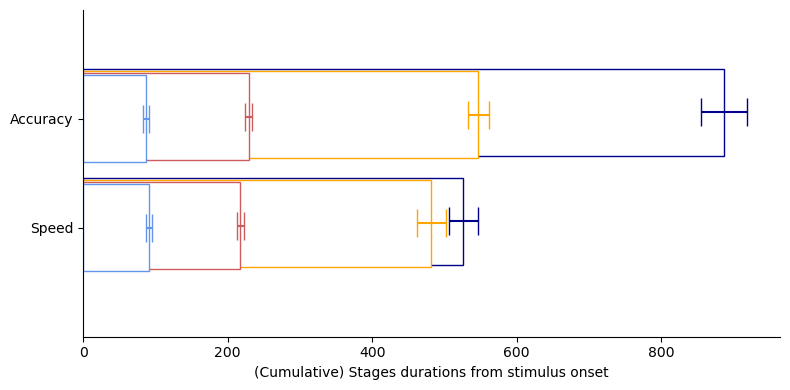

In [10]:
hsmm.visu.plot_latencies_average(condition_times, init.bump_width_samples, 1000/init.sf, 
                labels= ['Speed', 'Accuracy'], errs='ci');

Or with a line plot

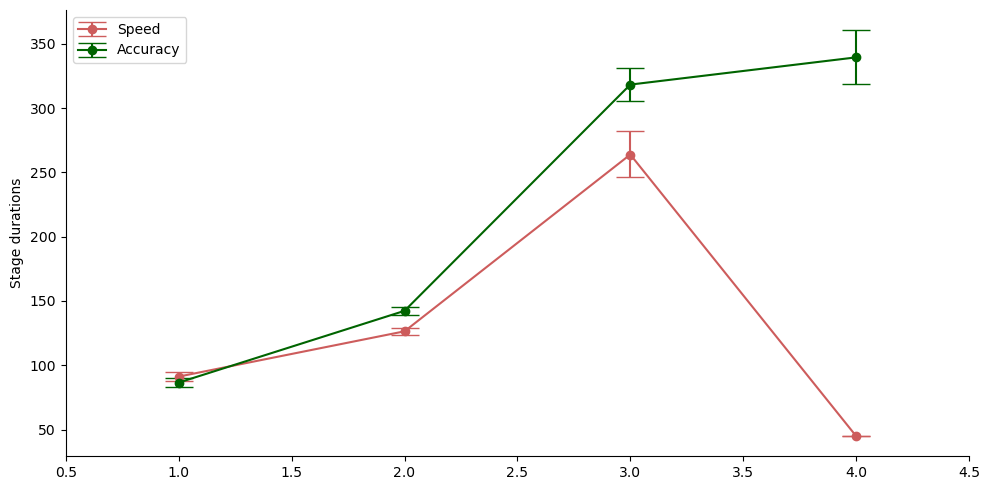

In [11]:
hsmm.visu.plot_latencies(condition_times,
    init.bump_width_samples, kind='point',legend=True,
    labels= ['Speed', 'Accuracy'], errs='ci', time_step=1000/init.sf,
    colors=["indianred","darkgreen"], figsize=(10,5));

Now applying the same model for conditions varying that much in speed might not be ideal and might hide important differences, a better way would be to fit two separate models

## 2. Estimate different topologies across conditions (left and right responses)

Given the conditions used in the dataset, it's is hard to think of difference in topologies arising from a condition where participant have to speed up *vs* a condition where they have to be accurate. A more interesting analysis regarding topologies would be response side. We should be able to see Lateralized Readiness Potential congruent with the response side, and as we expect this effect to be located on the bump representing response execution we could choose to only estimate this on the last bump.

In [12]:
subset = unstacked_data.where(eeg_data.event.str.contains('resp_left'),drop=True)#trials with left responses
hsmm_l_data = hsmm.utils.stack_data(subset)
init_l = hsmm.models.hsmm(hsmm_l_data,
                       sf=eeg_data.sfreq, cpus=cpus, estimate_parameters=False, magnitudes_to_fix=[0,1])

subset = unstacked_data.where(eeg_data.event.str.contains('resp_right'),drop=True)
hsmm_r_data = hsmm.utils.stack_data(subset)#trials with right responses
init_r = hsmm.models.hsmm(hsmm_r_data,
                       sf=eeg_data.sfreq, cpus=cpus, estimate_parameters=False, magnitudes_to_fix=[0,1])

In [13]:
left_stim = init_l.fit_single(n_bump, parameters=bests.sel(n_bumps=n_bump).parameters,magnitudes=bests.sel(n_bumps=n_bump).magnitudes)
right_stim = init_r.fit_single(n_bump, parameters=bests.sel(n_bumps=n_bump).parameters,magnitudes=bests.sel(n_bumps=n_bump).magnitudes)

Estimating parameters for 3 bumps model with 0 random starting points
Parameters estimated for 3 bumps model
Estimating parameters for 3 bumps model with 0 random starting points
Parameters estimated for 3 bumps model


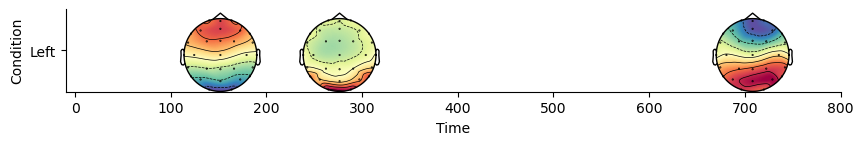

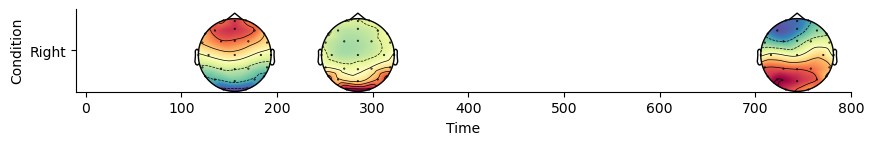

In [14]:
for condition in zip([left_stim, right_stim],
                     [init_l, init_r],
                     [hsmm_l_data, hsmm_r_data],
                    ['Left', 'Right']):
    electrodes = condition[1].compute_topo(eeg_data, condition[0].eventprobs)
    hsmm.visu.plot_topo_timecourse(electrodes, condition[1].bump_times(condition[0].eventprobs),
                          positions, bump_size=condition[1].bump_width_samples, time_step = 10,  
                          times_to_display = np.mean(condition[1].ends - condition[1].starts),max_time=800,
                          figsize=(10,1), ylabels={'Condition':[condition[3]]}, magnify=5)

Success, the only bump that changed in magnitude is the last one as imposed with a (slight) shift in frontal negativity from left to right (likely LRPs but again, only four participants). We also note that right responses are slightly shifted on the time scale, this is an emergent property as even if we fix the gamma parameters of stage duration to be the same, the likeliest bump location still spills on the bump location.

[Coming section : LOOCV for conditions]

# 3. Estimate different models for each condition


As commented in section 1 estimating a single model for conditions with such a difference on stage durations is a bad idea as we enforce the stages of two very different conditions to be described by the same gamma distribution. A better idea in such case is to fit two separate models and compare those, additionally doing so will eventually reveal whether there is a difference in the number of bumps between the conditions.

So here we will fit two completely separate models to the two speed-accuracy conditions. This is the most flexible approach and requires enough data in each condition, it should however systematically been tested when there is a suspicion on a difference on number of stages as the two previous applications assumed the same number of stage

### Applying HsMM separately for the speed condition

Initializing data for the speed condition

In [15]:
subset = unstacked_data.where(eeg_data.event.str.contains('SP'),drop=True)#speed trials
hsmm_speed_data = hsmm.utils.stack_data(subset)
init_speed = hsmm.models.hsmm(hsmm_speed_data,
                       sf=eeg_data.sfreq, cpus=cpus)

Estimating all solutions for maximal number of bumps (6) with 0 random starting points
Estimating parameters for 6 bumps model with 0 random starting points
Parameters estimated for 6 bumps model
Estimating all solutions for 5 number of bumps
Estimating all solutions for 4 number of bumps
Estimating all solutions for 3 number of bumps
Estimating all solutions for 2 number of bumps
Estimating all solutions for 1 number of bumps


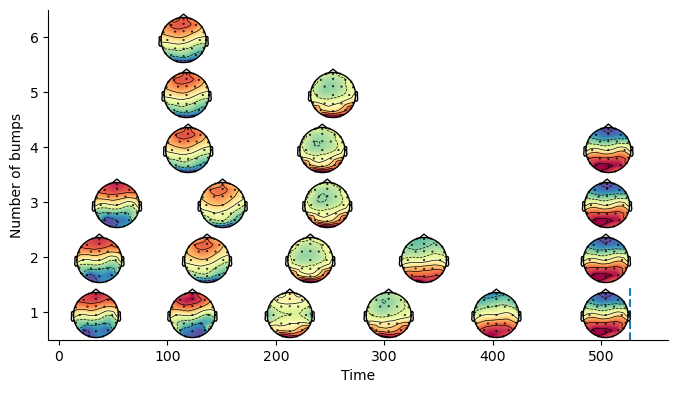

In [16]:
bests_speed = init_speed.backward_estimation(max_starting_points=1)

topo_bests_speed = init_speed.multiple_topologies(eeg_data, bests_speed.eventprobs)

hsmm.visu.plot_topo_timecourse(topo_bests_speed[::-1], [init_speed.bump_times(x) for x in bests_speed.eventprobs],
                          positions, bump_size=init_speed.bump_width_samples, time_step = 10, magnify=2, 
                          times_to_display = np.mean(init_speed.ends - init_speed.starts), 
                          figsize=(8,4), ylabels={'Number of bumps':np.arange(init_speed.max_bumps)+1})

Compute LOOCV on speed data only

LOOCV for model with 1 bump(s)
LOOCV for model with 2 bump(s)
LOOCV for model with 3 bump(s)
LOOCV for model with 4 bump(s)
LOOCV for model with 5 bump(s)
LOOCV for model with 6 bump(s)


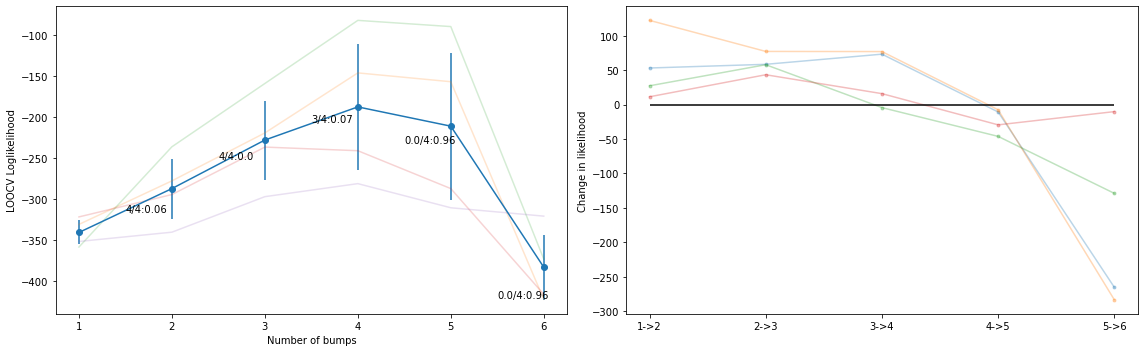

In [17]:
loocv = hsmm.utils.loocv_mp(init_speed, subset, bests_speed, cpus=cpus)
hsmm.visu.plot_LOOCV(loocv, pvals=True, test='t-test', indiv=True)#Colored shaded lines represent individuals

As in the general model, the best number of bumps given the absolute number of participant that improved and the t-test in the improvement is 3 bumps

### Applying HsMM separately for the accuracy condition

Initializing data for the accuracy condition

In [18]:
subset = unstacked_data.where(eeg_data.event.str.contains('AC'),drop=True)#Accuracy trials
hsmm_accuracy_data = hsmm.utils.stack_data(subset,'participant')
init_accuracy = hsmm.models.hsmm(hsmm_accuracy_data,
                       sf=eeg_data.sfreq, cpus=cpus)

Estimating the different number of bump solution using the backward estimation (first estimate max_bump solution then estimate max_bump - 1 solution by iteratively removing one of the bump and pick the one with the highest likelihood).

Note that because the minimum RT is higher in the accuracy condition, the maximum possible number of bumps is 7

Estimating all solutions for maximal number of bumps (8) with 0 random starting points
Estimating parameters for 8 bumps model with 0 random starting points
Parameters estimated for 8 bumps model
Estimating all solutions for 7 number of bumps
Estimating all solutions for 6 number of bumps
Estimating all solutions for 5 number of bumps
Estimating all solutions for 4 number of bumps
Estimating all solutions for 3 number of bumps
Estimating all solutions for 2 number of bumps
Estimating all solutions for 1 number of bumps


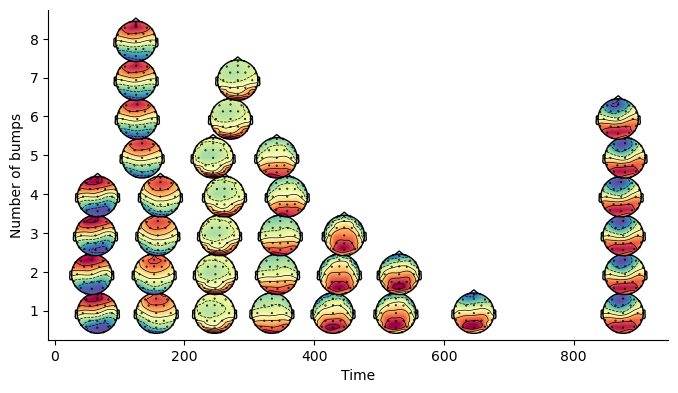

In [19]:
bests_accuracy = init_accuracy.backward_estimation(max_starting_points=1)

topo_bests_accuracy = init_accuracy.multiple_topologies(eeg_data, bests_accuracy.eventprobs)

hsmm.visu.plot_topo_timecourse(topo_bests_accuracy[::-1], [init_accuracy.bump_times(x) for x in bests_accuracy.eventprobs],
                          positions, bump_size=init_accuracy.bump_width_samples, time_step = 10, magnify=3, 
                          times_to_display = np.mean(init_accuracy.ends - init_accuracy.starts), 
                          figsize=(8,4), ylabels={'Number of bumps':np.arange(init_accuracy.max_bumps)+1})

And apply LOOCV for the accuracy fit

LOOCV for model with 1 bump(s)
LOOCV for model with 2 bump(s)
LOOCV for model with 3 bump(s)
LOOCV for model with 4 bump(s)
LOOCV for model with 5 bump(s)
LOOCV for model with 6 bump(s)
LOOCV for model with 7 bump(s)
LOOCV for model with 8 bump(s)


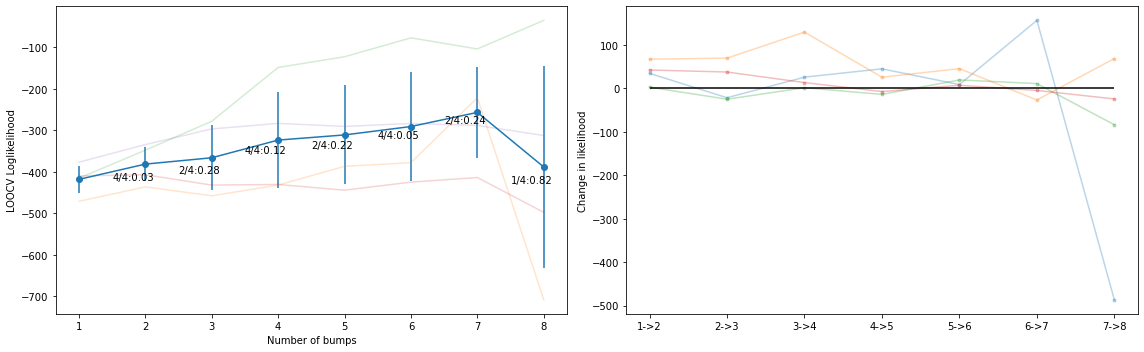

In [20]:
loocv = hsmm.utils.loocv_mp(init_accuracy, subset, bests_accuracy, cpus=cpus)
hsmm.visu.plot_LOOCV(loocv, pvals=True, test='t-test', indiv=True)#Colored shaded lines represent individuals

In the case of the accuracy condition the LOOCV is a bit harder to interpret with only 4 participants, but we note that only 2/4 improve from 2 to 3 bumps and 4/4 improve when going from 3 to 4 participants (note in this case the 6 bumps solution could have been prefered). If we settle to this 4 bump solution it is congruent with the result found by [Van Maanen, Portoles, & Borst (2021)](https://link.springer.com/article/10.1007/s42113-021-00105-2) where they estimate one bump more in the accuracy condition compared to the speed condition.

Despite having different models with different number of bumps we can still compare the bump topologies and time location:

In [21]:
estimates_speed = bests_speed.sel(n_bumps=3).drop_vars('n_bumps')
estimates_accuracy = bests_accuracy.sel(n_bumps=4).drop_vars('n_bumps')

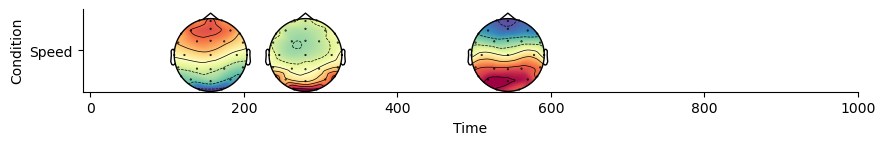

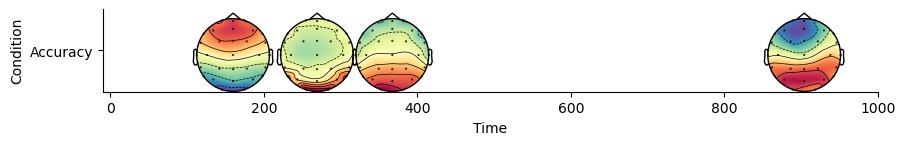

In [22]:
for condition in zip([estimates_speed, estimates_accuracy],
                     [init_speed, init_accuracy],
                     [hsmm_speed_data, hsmm_accuracy_data],
                    ['Speed', 'Accuracy']):
    electrodes = condition[1].compute_topo(eeg_data, condition[0].eventprobs)
    hsmm.visu.plot_topo_timecourse(electrodes, condition[1].bump_times(condition[0].eventprobs),
                          positions, bump_size=condition[1].bump_width_samples, time_step = 10,  
                          times_to_display = np.mean(condition[1].ends - condition[1].starts),max_time=1000,
                          figsize=(10,1), ylabels={'Condition':[condition[3]]}, magnify=5)

As well as the latencies of each stage

In [23]:
condition_times = []
for cond in zip([init_speed, init_accuracy],
                [estimates_speed, estimates_accuracy]):
    condition_times.append(cond[0].bump_times(cond[1].eventprobs, mean=False))
condition_times = np.array(condition_times, dtype=object)

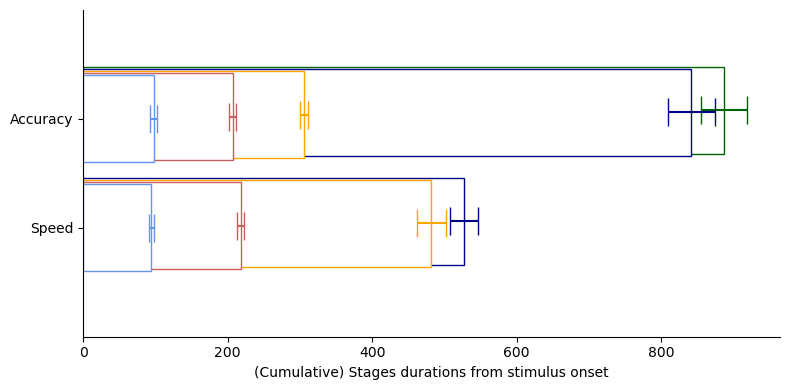

In [24]:
hsmm.visu.plot_latencies_average(condition_times, init.bump_width_samples, 1000/init.sf, 
                labels= ['Speed', 'Accuracy'], errs='ci');

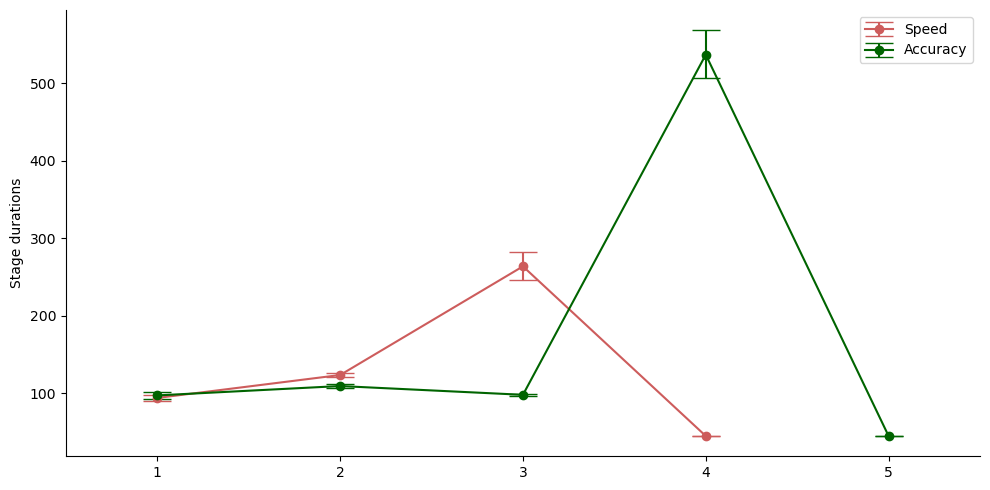

In [25]:
hsmm.visu.plot_latencies(condition_times,
    init.bump_width_samples, kind='point',legend=True,
    labels= ['Speed', 'Accuracy'], errs='ci', time_step=1000/init.sf,
    colors=["indianred","darkgreen"], figsize=(10,5));

And now we can describe our speed-accuracy manipulation in terms of stage number, stage duration and topologies!